In [16]:
import tensorflow as tf
import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.models import model_from_json 
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import np_utils
import glob      
import sys
import numpy as np
import matplotlib.pyplot as plt 
import PIL
from PIL import Image
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore") 
import mymodule
from mymodule import BatchGenerator
from mymodule import Make_Raw_List2
from mymodule import plot_loss_accuracy_graph

In [17]:
import pandas as pd
import numpy as np
import shutil
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
#label the normal and abnormal fundus in the dataframe
#1: healthy, 0:abnormal
def health(x):
    if x!=0:
        a=0
    else:
        a=1
    return a

def unhealth(x):
    if x!=0:
        a=1
    else:
        a=0
    return a

In [19]:
df=pd.read_csv('data.csv')
df['HE_on']=df['AMD']+df['RVO']+df['Gla']+df['MH']+df['DR']+df['RD']+df['RP']+df['AO']+df['DM']
df['HE']=df['HE_on'].apply(lambda x: health(x))
# df['unHE']=df['HE_on'].apply(lambda x: unhealth(x))
df['MD']=df['AMD']+df['RVO']+df['MH']+df['RD']+df['RP']
df=df.loc[df['MD']==1]
df

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE,MD
11,000004_00.jpg,3639,88,M,L,1,0,0,0,0,0,0,0,0,1,0,1
30,000009_01.jpg,213,73,F,L,0,0,0,0,0,0,1,0,0,1,0,1
31,000009_02.jpg,213,73,F,R,0,0,0,0,0,0,1,0,0,1,0,1
50,000018_01.jpg,4821,77,M,L,1,0,0,0,0,0,0,0,0,1,0,1
59,000021_01.jpg,3828,59,M,L,0,0,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12992,005369_03.jpg,3287,52,F,L,0,0,0,0,0,1,0,0,0,1,0,1
12993,005370_00.jpg,3287,52,F,L,0,0,0,0,0,1,0,0,0,1,0,1
12995,005370_02.jpg,2537,52,M,L,0,0,0,0,0,1,0,0,0,1,0,1
12996,005371_00.jpg,2537,52,M,L,0,0,0,0,0,1,0,0,0,1,0,1


In [20]:
# the 5 class classification, and their corresponding column index
od_d={'MH': 8, 'RP': 11, 'AMD': 5, 'RVO': 6,  'RD': 10}

In [21]:
#create the str format label
df['label']=0
for i in df.index:
    for k in od_d.keys():
        if df.loc[i,k]!=0:
            df.loc[i,'label']=str(k)
            break
df       

,filename,ID,age,sex,LR,AMD,RVO,Gla,MH,DR,RD,RP,AO,DM,HE_on,HE,MD,label
11,000004_00.jpg,3639,88,M,L,1,0,0,0,0,0,0,0,0,1,0,1,AMD
30,000009_01.jpg,213,73,F,L,0,0,0,0,0,0,1,0,0,1,0,1,RP
31,000009_02.jpg,213,73,F,R,0,0,0,0,0,0,1,0,0,1,0,1,RP
50,000018_01.jpg,4821,77,M,L,1,0,0,0,0,0,0,0,0,1,0,1,AMD
59,000021_01.jpg,3828,59,M,L,0,0,0,0,0,1,0,0,0,1,0,1,RD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12992,005369_03.jpg,3287,52,F,L,0,0,0,0,0,1,0,0,0,1,0,1,RD
12993,005370_00.jpg,3287,52,F,L,0,0,0,0,0,1,0,0,0,1,0,1,RD
12995,005370_02.jpg,2537,52,M,L,0,0,0,0,0,1,0,0,0,1,0,1,RD
12996,005371_00.jpg,2537,52,M,L,0,0,0,0,0,1,0,0,0,1,0,1,RD


In [22]:
# select the useful information from the dataset
df=df[['filename','label']]
df=df.loc[df['label']!=0]
df

,filename,label
11,000004_00.jpg,AMD
30,000009_01.jpg,RP
31,000009_02.jpg,RP
50,000018_01.jpg,AMD
59,000021_01.jpg,RD
...,...,...
12992,005369_03.jpg,RD
12993,005370_00.jpg,RD
12995,005370_02.jpg,RD
12996,005371_00.jpg,RD


In [23]:
#initiate the 4-fold cross validation
kf = KFold(n_splits = 4)                       

In [24]:
#initiate the image data generator, and rescale the iamge
idg = ImageDataGenerator(rescale=1./255)

In [25]:
# help to produce the name of the model generated during cross-validation
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

In [27]:
#create the resnet model
model = ResNet50(include_top=False, input_shape=(256, 256, 3))
flat1 = Flatten()(model.output)
class1 = Dense(512, activation='relu')(flat1)
output = Dense(5, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [28]:
#get the path
root=os.getcwd()
root

'/Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master'

In [32]:
# 5 class classification, MH, RP, AMD, RVO, RD
# resnet, cross validation
# store the accuracy result
TRAINING_ACCURACY={}
VALIDATION_ACCURACY = {}
TEST_ACCURACY = {}
#set the directory
save_dir = root+'/model'
image_dir = root+'/img'
fold_var = 1
#shuffle the dataset
df_t=df.sample(frac=1)
#train-test split, train will be further separated into train and validation
df_t_train=df_t.iloc[:int(len(df_t)*0.8),]
df_t_test=df_t.iloc[int(len(df_t)*0.8):,]
#get the test data
test_data_generator = idg.flow_from_dataframe(df_t_test, directory = image_dir,
					x_col = "filename", y_col = "label",
					class_mode = "categorical", shuffle = True)
cv_fold=1
for train_index, val_index in kf.split(df_t_train):
	training_data = df_t_train.iloc[train_index, :]
	validation_data = df_t_train.iloc[val_index, :]
	#get the training data
	train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "filename", y_col = "label",
						       class_mode = "categorical", shuffle = True)
	#get the validation data
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "filename", y_col = "label",
							class_mode = "categorical", shuffle = True)
	# COMPILE NEW MODEL
	model.compile(loss='categorical_crossentropy',
		      optimizer='sgd',
		      metrics=['accuracy'])
	
	# CREATE CALLBACKS
	checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(cv_fold), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
	#train the model
	history = model.fit(train_data_generator,
			    epochs=5,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)
	TRAINING_ACCURACY[str(cv_fold)]=history.history['accuracy']
	VALIDATION_ACCURACY[str(cv_fold)]=history.history['val_accuracy']
	#save the model
	model.save(save_dir+'/model_R5_CV_'+str(cv_fold)+'.h5')
	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights(save_dir+"/model_R5_CV_"+str(cv_fold)+".h5")
	results = model.evaluate(test_data_generator)
	results = dict(zip(model.metrics_names,results))
	TEST_ACCURACY[str(cv_fold)]=results['accuracy']
	tf.keras.backend.clear_session()
	cv_fold+=1
	

Found 508 validated image filenames belonging to 5 classes.
Found 1521 validated image filenames belonging to 5 classes.
Found 508 validated image filenames belonging to 5 classes.
Epoch 1/5
48/48 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.8659 
Epoch 1: val_accuracy improved from -inf to 0.10630, saving model to /Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master/modelmodel_1.h5
48/48 [==============================] - 805s 17s/step - loss: 0.4285 - accuracy: 0.8659 - val_loss: 2.2366 - val_accuracy: 0.1063
Epoch 2/5
48/48 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9717 
Epoch 2: val_accuracy did not improve from 0.10630
48/48 [==============================] - 799s 17s/step - loss: 0.0922 - accuracy: 0.9717 - val_loss: 3.0685 - val_accuracy: 0.1063
Epoch 3/5
48/48 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9928 
Epoch 3: val_accuracy improved from 0.10630 to 0.11811, saving model to

In [34]:
VALIDATION_ACCURACY

{'1': [0.10629921406507492,
  0.10629921406507492,
  0.11811023950576782,
  0.1988188922405243,
  0.11811023950576782],
 '2': [0.23274162411689758,
  0.11439841985702515,
  0.10059171915054321,
  0.10650887340307236,
  0.1794871836900711],
 '3': [0.21301774680614471,
  0.20118343830108643,
  0.216962531208992,
  0.2958579957485199,
  0.42603549361228943],
 '4': [0.5798816680908203,
  0.6883628964424133,
  0.7850098609924316,
  0.844181478023529,
  0.8974359035491943]}

In [35]:
#get the maximum validation for each validation set
val_acc_l=[]
for k in VALIDATION_ACCURACY.keys():
    val_acc_l.append(max(VALIDATION_ACCURACY[k]))
val_acc_l

[0.1988188922405243,
 0.23274162411689758,
 0.42603549361228943,
 0.8974359035491943]

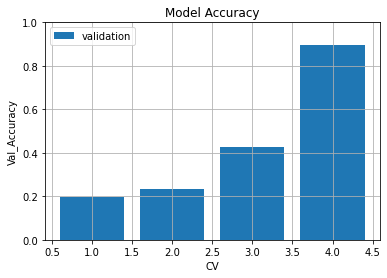

In [37]:
#plot the validation accuracy for different cross validation set
fig1 = plt.gcf()
plt.bar([1,2,3,4],val_acc_l)
# plt.plot(training_accuracy)
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Val_Accuracy')
plt.xlabel('CV')
plt.legend(['validation'])
plt.show()

In [38]:
#load test model
test_model = keras.models.load_model('/Users/ziyingye/Desktop/stats/stats402/data/Fundus_Diagnosis-master/modelmodel_1.h5')

In [40]:
#load test data
test_ds=tf.keras.preprocessing.image_dataset_from_directory(
  root+'/cate_c/test/RVO_copy',
  image_size=(256, 256),
  # batch_size=16,
  shuffle=False)

Found 155 files belonging to 1 classes.


In [41]:
#predict the data
df_p=pd.DataFrame(test_model.predict(test_ds))
df_p

5/5 [==============================] - 23s 4s/step


,0,1,2,3,4
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
150,0.0,0.0,1.0,0.0,0.0
151,0.0,0.0,1.0,0.0,0.0
152,0.0,0.0,1.0,0.0,0.0
153,0.0,0.0,1.0,0.0,0.0
